# Quantization Modes


In [1]:
# define imports
import numpy as np
from pathlib import Path

from quantization_notes.utils import plot_table
from quantization_notes.quantization_modes import (
    quantize_symmetric_full,
    quantize_symmetric_restricted,
    quantize_asymmetric,
    dequantize_symmetric,
    dequantize_asymmetric,
)

OUTPUT_DIR = Path("../output")

## Symmetric Quantization

In symmetric quantization, we map the floating-point range to the quantized range with respect to $0$ - think along the lines of $[-100,100]$. To do so, we choose $\alpha = \max|x_f| = -\max(x_f)$ and $\max(x_f)$, where $x_f$ is some number in the floating-point range.

Additionally, we choose $N_{bins} = 2^n$, where $n$ is the number of bits we want to quantize to. In order to derive our quantization range with respect to $0$, we simply place half the bins before $0$ and the other half after $0$.

Example: Let's say we wanted an 8-bit quantization range. Then, the number of bins would be $N_{bins} = 2^8 = 256 \implies [0,255] \implies [-128,127]$. That is the "full range" symmetric around 0. However in practice, this range is generally "restricted" to $[-127,127]$. We can derive scaling factors to map from floating point to quantized for both ranges:

$$
\def\arraystretch{1.5}
\begin{array}{c|c|c}
& \text{Full Range} & \text{Restricted Range} \\ \hline
\text{Quantized Range} & [-\frac{N_{bins}}{2},\frac{N_{bins}}{2}-1] & [-(\frac{N_{bins}}{2}-1),\frac{N_{bins}}{2}-1] \\ \hline
\text{8-bit Example} & [-128,127] & [-127,127] \\ \hline
\text{Scale Factor} & q_x=\frac{(2^n-1)/2}{\alpha} & q_x=\frac{2^{n-1}-1}{\alpha} \\
\end {array}
$$

Finally, we can compute our symmetric quantized tensor clamped to our range $[a,b]$:

$$x_q = \text{clamp}(\text{round}(q_xx_f);a;b)$$

**Note**: Clamping is just a fancy way of setting any value outside of the range $[a,b]$ to $a$ or $b$. For example, if we have an interval of $[0,1]$, values smaller than 0 become 0, and values larger than 1 become 1. In reality, this is more of a technique to ensure that quantized values remain in the specific range.


In [2]:
# Initialize some random data
data = np.random.uniform(-500, 1000, size=(5, 5))
print(f"unquantized data:\n {data} \n")

# Quantize to 8-bits using symmetric full mode
quantized_symmetric_full_scale, quantized_symmetric_full_data = quantize_symmetric_full(
    8, data
)
print(f"quantized symmetric full\n {quantized_symmetric_full_data} \n")

# Quantize to 8-bits using symmetric restricted mode
(
    quantized_symmetric_restricted_scale,
    quantized_symmetric_restricted_data,
) = quantize_symmetric_restricted(8, data)
print(f"quantized symmetric restricted\n {quantized_symmetric_restricted_data} \n")

unquantized data:
 [[ 160.7689266  -353.00649264  262.79404959 -485.47455996 -394.00752719]
 [ 286.24547078 -160.65153884   24.38447862  312.17802835  586.90009333]
 [ 711.74862962 -191.88597349  885.5046842  -456.27861689 -458.82752378]
 [ 736.90623882  450.02132435  758.79509932  415.99385631  699.08136712]
 [ 390.21900342 -354.77324198  230.10376581 -120.87300251  683.61069568]] 

quantized symmetric full
 [[ 23. -51.  38. -70. -57.]
 [ 41. -23.   4.  45.  85.]
 [102. -28. 127. -66. -66.]
 [106.  65. 109.  60. 101.]
 [ 56. -51.  33. -17.  98.]] 

quantized symmetric restricted
 [[ 23. -51.  38. -70. -57.]
 [ 41. -23.   3.  45.  84.]
 [102. -28. 127. -65. -66.]
 [106.  65. 109.  60. 100.]
 [ 56. -51.  33. -17.  98.]] 



## Visualize Symmetric Quantization


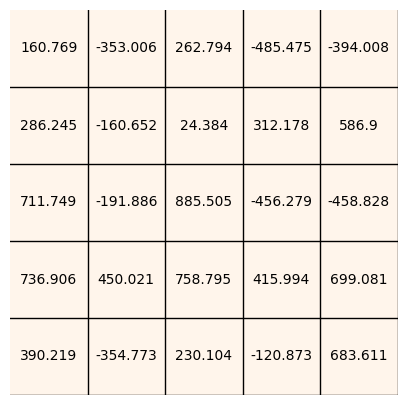

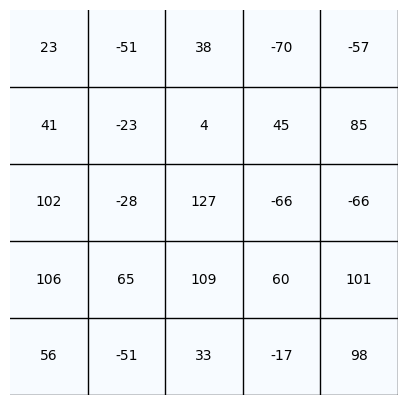

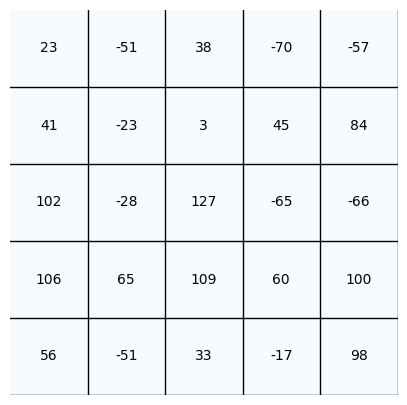

In [3]:
plot_table(data, str(OUTPUT_DIR / "unquantized-data.png"), "Oranges", "black", "black")
plot_table(
    quantized_symmetric_full_data,
    str(OUTPUT_DIR / "quantized-symmetric-full.png"),
    "Blues",
    "black",
    "black",
)
plot_table(
    quantized_symmetric_restricted_data,
    str(OUTPUT_DIR / "quantized-symmetric-restricted.png"),
    "Blues",
    "black",
    "black",
)

## Asymmetric Quantization

Compared to symmetric quantization, asymmetric also known as _affine_ quantization has a few key differences:

- Instead of mapping the floating point range $[-\alpha, \alpha]$ to some quantized range symmetric to $0$, we choose $[\alpha, \beta]$, where $\alpha=\min(x_f)$ and $\beta=\max(x_f)$
- Since the mapping is no longer symmetric to $0$, we have to introduce a **zero-point** $z_{x}$ also known as _quantization bias_. This serves to actually represent $0$ in the quantized range.
- Additionally, the quantized range is now represented by $[0,2^n-1]$.

We can derive a scaling factor for asymmetric quantization:

$$
\def\arraystretch{1.5}
\begin{array}{c|c}
\text{Quantized Range} & [0,2^n-1] \\ \hline
\text{8-bit Example} & [0, 255] \\ \hline
\text{Scale Factor} & q_x=\frac{2^n-1}{\beta-\alpha} \\
\end {array}
$$

To find the zero-point $z_{x}$, simply take the minimum value of $x_f$ i.e. $\alpha$ and scale it to its representation in the new quantized range, which is:

$$
z_x = \text{round}(q_x\alpha)
$$

Finally, we can compute our asymmetric quantized tensor $q_x$ adjusted for bias:

$$
x_q = \text{clamp}(\text{round}(q_xx_f)-z_x;0;2^n-1)
$$


## Quantize and Visualize Asymmetric Mode


quantized asymmetric 
 [[120.  24. 139.   0.  17.]
 [143.  60.  95. 148. 199.]
 [222.  54. 255.   5.   5.]
 [227. 174. 231. 167. 220.]
 [163.  24. 133.  68. 217.]] 



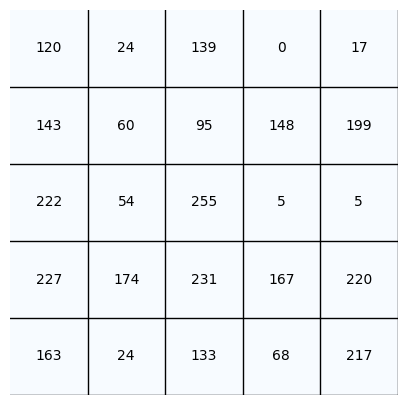

In [4]:
# 8-bit Asymmetric Quantization
(
    quantized_asymmetric_scale,
    quantized_asymmetric_zero_point,
    quantized_asymmetric_data,
) = quantize_asymmetric(8, data)
print(f"quantized asymmetric \n {quantized_asymmetric_data} \n")

plot_table(
    quantized_asymmetric_data,
    str(OUTPUT_DIR / "quantized-asymmetric.png"),
    "Blues",
    "black",
    "black",
)

## Dequantization and Error

Dequantization of a symmetric quantization is as simple as computing the quotient of the quantized tensor $x_q$ and the scale factor $q_x$:

$$\hat{x_f} = \frac{x_q}{q_x}$$

Similarly, dequantization of an asymmetric quantization is as follows adjusting for the zero-point:

$$\hat{x_f} = \frac{x_q+z_x}{q_x}$$

However as expected, there is some error associated with the process of quantizing a tensor and then dequantizing it. We can compute that error using mean-squared error (MSE):

$$
\text{MSE} = \frac{1}{n}\displaystyle\sum(\hat{x_f}-x_f)^2
$$


In [5]:
def mse(a: np.array, b: np.array) -> float:
    return np.mean((a - b) ** 2)


dequantized_symmetric_full_data = dequantize_symmetric(
    quantized_symmetric_full_scale, quantized_symmetric_full_data
)
dequantized_symmetric_full_error = mse(dequantized_symmetric_full_data, data)

print(f"dequantized symmetric full data: \n {dequantized_symmetric_full_data} \n")
print(f"dequantized symmetric full error: \n {dequantized_symmetric_full_error:.2}% \n")

dequantized_symmetric_restricted_data = dequantize_symmetric(
    quantized_symmetric_restricted_scale, quantized_symmetric_restricted_data
)
dequantized_symmetric_restricted_error = mse(
    dequantized_symmetric_restricted_data, data
)

print(
    f"dequantized symmetric restricted data: \n {dequantized_symmetric_restricted_data} \n"
)
print(
    f"dequantized symmetric restricted error: \n {dequantized_symmetric_restricted_error:.2}% \n"
)

dequantized_asymmetric_data = dequantize_asymmetric(
    quantized_asymmetric_scale,
    quantized_asymmetric_zero_point,
    quantized_asymmetric_data,
)
dequantized_asymmetric_error = mse(dequantized_asymmetric_data, data)

print(f"dequantized asymmetric data: \n {dequantized_asymmetric_data} \n")
print(f"dequantized asymmetric error: \n {dequantized_asymmetric_error:.2}% \n")

dequantized symmetric full data: 
 [[ 159.73809989 -354.20187368  263.91512156 -486.15943446 -395.87268235]
 [ 284.7505259  -159.73809989   27.78053911  312.53106501  590.33645613]
 [ 708.40374736 -194.46377378  882.03211681 -458.37889535 -458.37889535]
 [ 736.18428647  451.43376057  757.0196908   416.70808668  701.45861258]
 [ 388.92754757 -354.20187368  229.18944767 -118.06729123  680.62320825]] 

dequantized symmetric full error: 
 4.0% 

dequantized symmetric restricted data: 
 [[ 160.36699005 -355.59636924  264.95415748 -488.07344798 -397.43123621]
 [ 285.87159096 -160.36699005   20.91743348  313.76150227  585.68813758]
 [ 711.19273849 -195.22937919  885.5046842  -453.21105884 -460.18353667]
 [ 739.0826498   453.21105884  760.00008329  418.3486697   697.24778283]
 [ 390.45875839 -355.59636924  230.09176833 -118.53212308  683.30282718]] 

dequantized symmetric restricted error: 
 4.0% 

dequantized asymmetric data: 
 [[ 161.29167578 -354.84168672  263.44307045 -483.87502735 -392.47